In [1]:
import os
import numpy as np
import re
import csv

import sys
sys.path.insert(0, '../..')
import metrics.charades_classify as cc
from datasets.prepare_dataset import load_labels_file

import matplotlib.pyplot as plt
from inspect import signature

from scipy import signal
from torch.nn import MaxPool1d

import torch

In [2]:
# gt_path = '/data/Datasets/Charades/Annotations/Charades_v1_causal_clip_test.txt'
classes_file = '/Volumes/UBUNTU 18_0/PAKOVA/data/Charades_v1_classes.txt'
classes_att_file = '/Volumes/UBUNTU 18_0/PAKOVA/data/Charades_v1_attributes_class.csv'
classes_map_file = '/Volumes/UBUNTU 18_0/PAKOVA/data/Charades_v1_mapping.txt'
# gt_path = '/data/Datasets/Charades/Annotations/Charades_v1_causal_allFrames_test.txt'
gt_path = '/Volumes/UBUNTU 18_0/PAKOVA/data/Charades_v1_causal_test.txt'

per_frame = True

# Load classes
classes = load_labels_file(classes_file)

dir_name = "/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/"
files_dir =  "causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop"

num_classes = 157
num_per_line = num_classes + 1

In [3]:
result_files = sorted(
    [os.path.join(dir_name, files_dir, f) for f in os.listdir(dir_name + files_dir) if f.endswith('.txt')])

test_ids = []
test_classes = []
for fname in result_files:
    print(fname)
    text = ''
    with open(fname, 'r', encoding ="ISO-8859-1") as file:
        for line in file:
            text += ' '+line.strip()

    lines_text = [t for t in text.split(' ') if t != '']
    split_text = [lines_text[i-num_per_line:i] for i in range(num_per_line, len(lines_text), num_per_line)]
    
    v_ids = [st[0] for st in split_text]
    v_scores = [list(map(float, st[1:])) for st in split_text]
    
    sorted_ind = np.argsort(v_ids)
    v_ids = list(np.array(v_ids)[sorted_ind])
    v_scores = list(np.array(v_scores)[sorted_ind])
    
#     ids, classes = cc.read_file(fname)
    test_ids += v_ids
    test_classes += v_scores
    print(len(test_ids), len(test_classes))

/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop_0.txt
134705 134705
/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop_1.txt
282894 282894
/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop_2.txt
430817 430817
/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop_3.txt
575755 575755
/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop_4.txt
716754 716754
/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/causal_eval_charades_r50_i3d_nl_8x8_stream_centerCrop/causal_eval_charades_r50_i3d_nl_8x8_

In [10]:
ids_file = dir_name + files_dir + '_ids'
preds_file = dir_name + files_dir + '_preds'

# np.save(ids_file, test_ids)
# np.save(preds_file, test_classes)

NameError: name 'dir_name' is not defined

In [13]:
ids_file = dir_name + files_dir + '_ids.npy'
preds_file = dir_name + files_dir + '_preds.npy'

test_ids = np.load(ids_file, allow_pickle=True)[()]

In [6]:
def divide_per_clip(ids, classes):
    clips_ids = []
    clips_classes = []

    video_name = None
    for i, video_frame in enumerate(ids):
        name = video_frame.split('_')[0]
        if name != video_name:
            # new video! But first, save old video
            if i > 0:
                clips_ids.append(np.array(video_ids))
                clips_classes.append(np.array(video_classes))
            # star new one
            video_ids = []
            video_classes = []
            video_name = name
            
        video_ids.append(video_frame)
        video_classes.append(classes[i])
        
    # Append last video
    clips_ids.append(np.array(video_ids))
    clips_classes.append(np.array(video_classes))
        
    return np.array(clips_ids), np.array(clips_classes)

In [3]:
gt_ids, gt_classes = cc.read_file(gt_path) 
gt_classes = np.array(gt_classes)

n_test = len(gt_ids)

# Check if there are duplicate items
test_ids2, test_index_order = np.unique(test_ids, return_index=True)
test_classes2 = np.array(test_classes)[test_index_order]

# Dividing per clip
gt_clips_ids, gt_clips_classes = divide_per_clip(gt_ids, gt_classes)
test_clips_ids, test_clips_classes = divide_per_clip(test_ids2, test_classes2)

In [17]:
test_ids = sorted(test_ids)
gt_ids = sorted(gt_ids)

In [24]:
equal = set(test_ids)
missing = [x for x in gt_ids if x not in equal]
missing_ids = [i for i, x in enumerate(gt_ids) if x not in equal]

In [22]:
len(test_ids), len(gt_ids), len(equal), len(missing)

(1153504, 1153408, 1153401, 7)

In [23]:
missing

['0UPBN_000836',
 '3AVAH_000316',
 '6C0BK_000904',
 'FAO7J_001355',
 'GI61S_000694',
 'OOWBP_001629',
 'SUG5S_000187']

In [30]:
gt_classes2 = np.delete(gt_classes, missing_ids, axis=0)

In [31]:
gt_classes.shape, gt_classes2.shape

((1153408, 157), (1153401, 157))

In [51]:
sum_samples = gt_classes.sum(0)
sum_samples

array([ 55943.,  42090.,  36947.,  18438.,  30996.,  11432.,  30588.,
        11747.,  36271.,  42458.,   7306.,  84679.,  19739.,   3281.,
        42245., 106040.,  73097.,   9539.,  21294.,  19010.,  66220.,
        16218.,  11803.,  13718.,   3303.,   8881.,  83142.,  15909.,
        13528.,  11241.,  15746.,   2423.,  49759.,  72063.,  19810.,
        17837.,   9543.,  18716.,  23724.,   7248.,  39442.,  10824.,
        11760.,  13473.,  10588.,   1141.,   5931.,  44558.,   4421.,
         8186.,   4920.,  49645.,  39782.,  22253.,  13776.,  12165.,
        11459.,  12592.,   5371., 162213.,   3067., 131311.,  44339.,
        44897.,   3788.,  30037.,   6015.,  38198.,   7098.,   8187.,
        65524.,  16671.,  42469.,  13433.,   9000.,  13886.,  40550.,
         8764.,  26921.,   6128.,   3880.,  27976.,  32043.,   8316.,
        17976.,   4596.,   4531.,  17857.,  23664.,   3040.,   3095.,
         2884.,  26438.,   8632.,  10904.,   2776.,  36741.,  49704.,
        37055.,   68

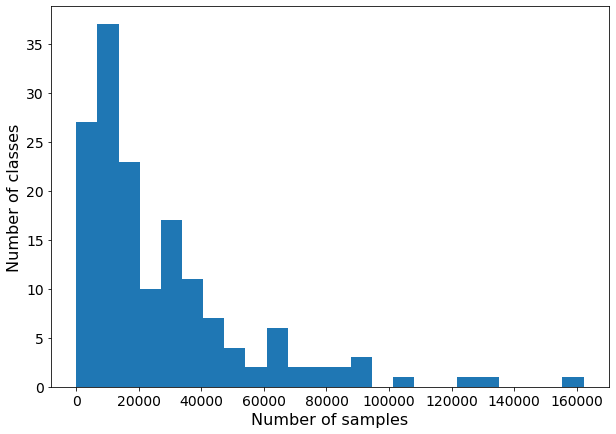

In [68]:
plt.rcParams.update({'font.size': 14})

bins = np.linspace(0, max(sum_samples), 25)

fig = plt.figure(figsize=(10,7))
plt.hist(sum_samples, bins)
plt.xlabel('Number of samples', fontsize=16)
plt.ylabel('Number of classes', fontsize=16)
fig.savefig('/Volumes/UBUNTU 18_0/PAKOVA/outputs/Charades/charades_num_samples_hist.pdf')
plt.show()

In [6]:
def video_output(outputs):
    num_clips, num_classes = outputs.shape
    max_pool = MaxPool1d(num_clips)
    
    outputs = torch.tensor(outputs)

    data = outputs.view(1, -1, num_classes).contiguous()
    data = data.permute(0, 2, 1).contiguous()

    data = max_pool(data)
    video_data = data.view(num_classes).contiguous()

    return video_data

def select_n_clips(video_classes, n=10):
    num_frames = len(video_classes)
    ids = np.linspace(0, num_frames-1, n, dtype=int)
    
    return video_classes[ids]

In [7]:
def map_func(submission_array, gt_array):
    """ Returns mAP, weighted mAP, AP array, precisions, recall and calibrated AP"""
    m_aps = []
    c_aps = []
    fprs = []
    a_prec = np.zeros(submission_array.shape)
    a_recall = np.zeros(submission_array.shape)
    n_samples = submission_array.shape[0]
    n_classes = submission_array.shape[1]
    for oc_i in range(n_classes):
        sorted_idxs = np.argsort(-submission_array[:, oc_i])
        sorted_gt = gt_array[:, oc_i][sorted_idxs]
        tp = sorted_gt == 1
        fp = np.invert(tp)
        n_pos = tp.sum()
        n_gt = sorted_gt.sum()

        t_pcs = np.cumsum(tp)
        f_pcs = np.cumsum(fp)
        prec = t_pcs / (f_pcs+t_pcs).astype(float)
        recall = t_pcs / n_gt.astype(float)
        
        fpr = f_pcs / (n_samples - n_gt).astype(float)
        c_prec = recall / (recall + fpr)
        
        fprs.append(c_prec)
        # Calibrated prec
#         w = (n_samples - n_gt) / float(n_gt)
#         c_t_pcs = t_pcs * w
#         c_prec = c_t_pcs / (f_pcs + c_t_pcs).astype(float)

        avg_prec = 0
        c_avg_prec = 0
        for i in range(submission_array.shape[0]):
            if tp[i]:
                avg_prec += prec[i]
                c_avg_prec += c_prec[i]
        m_aps.append(avg_prec / n_pos.astype(float))
        c_aps.append(c_avg_prec / n_pos.astype(float))
        a_prec[:, oc_i] = prec
        a_recall[:, oc_i] = recall
    m_aps = np.array(m_aps)
    c_aps = np.array(c_aps)
    m_ap = np.nanmean(m_aps)
    c_ap = np.nanmean(c_aps)
    w_ap = np.nansum(m_aps * gt_array.sum(axis=0) / gt_array.sum().astype(float))
    return m_ap, w_ap, m_aps, a_prec, a_recall, c_ap


def charades_map(submission_array, gt_array):
    """
    Approximate version of the charades evaluation function
    For precise numbers, use the submission file with the official matlab script
    """

    fix = submission_array.copy()
    empty = np.sum(gt_array, axis=1) == 0
    fix[empty, :] = np.NINF

    return map_func(fix, gt_array)

In [21]:
len(test_classes), gt_classes.shape

(1153512, (1153408, 157))

In [18]:
# per frame using mean of all clips
mean_map, mean_wap, _, _, _, mean_cap = charades_map(test_classes2, gt_classes)

# per clip result
test_classes_n = [select_n_clips(np.array(clip_data), n=10) for clip_data in test_clips_classes]

test_clip_n_mean = np.array([video_output(t_c).numpy() for t_c in test_classes_n])
gt_clips_n_mean = np.array([(sum(gt_c) > 0).astype(int) for gt_c in gt_clips_classes])

map_10_mean, _, _, _, _, cap_10_mean = charades_map(test_clip_n_mean, gt_clips_n_mean)

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(mean_map, mean_cap))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(map_10_mean, cap_10_mean))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 36 but corresponding boolean dimension is 1153408

In [ ]:
results = {
    'map': mean_map,
    'cap': mean_cap,
    'map_10': map_10_mean, 
    'cap_10': cap_10_mean
}

output_file = dir_name + files_dir + '_results'
np.save(output_file, results)

In [25]:
baseline8_centerCrop = np.load(
    dir_name + 'causal_eval_charades_resnet50baseline8_config1_valCenterCrop_results.npy', allow_pickle=True)[()]
print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_centerCrop['map'], baseline8_centerCrop['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_centerCrop['map_10'], baseline8_centerCrop['cap_10']))

print('\n')

baseline8_centerCrop2 = np.load(
    dir_name + 'eval_pred_charades_r50i3d_baseline8_stream_centerCrop_results.npy', allow_pickle=True)[()]
print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_centerCrop2['map'], baseline8_centerCrop2['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_centerCrop2['map_10'], baseline8_centerCrop2['cap_10']))

Per frame:
mAP: 14.95%, cAP: 79.53%
Per clip:
mAP: 26.92%, cAP: 80.31%


Per frame:
mAP: 14.95%, cAP: 79.53%
Per clip:
mAP: 26.92%, cAP: 80.31%


In [15]:
baseline8_fullyConv = np.load(
    dir_name + 'causal_eval_charades_resnet50baseline8_config1_valFullyConv_results.npy', allow_pickle=True)[()]

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_fullyConv['map'], baseline8_fullyConv['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_fullyConv['map_10'], baseline8_fullyConv['cap_10']))

print('\n')

baseline8_fullyConv2 = np.load(
    dir_name + 'causal_eval_charades_resnet50baseline8_config1_valFullyConv_print_results.npy', allow_pickle=True)[()]
print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_fullyConv2['map'], baseline8_fullyConv2['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline8_fullyConv2['map_10'], baseline8_fullyConv2['cap_10']))

Per frame:
mAP: 14.07%, cAP: 76.87%
Per clip:
mAP: 24.99%, cAP: 77.62%


Per frame:
mAP: 13.20%, cAP: 75.30%
Per clip:
mAP: 24.13%, cAP: 76.58%


In [23]:
nl8_centerCrop = np.load(
    dir_name + 'eval_pred_charades_r50i3d_nl8_stream_centerCrop_results.npy', allow_pickle=True)[()]

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl8_centerCrop['map'], nl8_centerCrop['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl8_centerCrop['map_10'], nl8_centerCrop['cap_10']))

Per frame:
mAP: 17.17%, cAP: 81.98%
Per clip:
mAP: 30.28%, cAP: 82.49%


In [24]:
nl8_fullyConv = np.load(
    dir_name + 'causal_eval_charades_resnet50nl8_config1_valFullyConv_results.npy', allow_pickle=True)[()]

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl8_fullyConv['map'], nl8_fullyConv['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl8_fullyConv['map_10'], nl8_fullyConv['cap_10']))

Per frame:
mAP: 17.17%, cAP: 81.98%
Per clip:
mAP: 30.28%, cAP: 82.49%


In [23]:
baseline32_centerCrop = np.load(
    dir_name + 'causal_eval_charades_resnet50baseline32_config1_centerCrop_results.npy', allow_pickle=True)[()]

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline32_centerCrop['map'], baseline32_centerCrop['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline32_centerCrop['map_10'], baseline32_centerCrop['cap_10']))

Per frame:
mAP: 17.39%, cAP: 82.26%
Per clip:
mAP: 31.05%, cAP: 83.00%


In [10]:
baseline32_fullyConv = np.load(
    dir_name + 'causal_eval_charades_resnet50baseline32_config1_fullyConv_results.npy', allow_pickle=True)[()]

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline32_fullyConv['map'], baseline32_fullyConv['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(baseline32_fullyConv['map_10'], baseline32_fullyConv['cap_10']))

Per frame:
mAP: 16.93%, cAP: 81.08%
Per clip:
mAP: 29.41%, cAP: 81.16%


In [10]:
nl32_centerCrop = np.load(
    dir_name + 'causal_eval_charades_resnet50nl32_full_config1_valcentercrop_results.npy', allow_pickle=True)[()]

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl32_centerCrop['map'], nl32_centerCrop['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl32_centerCrop['map_10'], nl32_centerCrop['cap_10']))

Per frame:
mAP: 18.07%, cAP: 82.89%
Per clip:
mAP: 31.99%, cAP: 83.73%


In [15]:
nl32_fullyConv = np.load(
    dir_name + 'causal_eval_charades_resnet50nl32_full_config1_valFullyConv_results.npy', allow_pickle=True)[()]

print('Per frame:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl32_fullyConv['map'], nl32_fullyConv['cap']))
print('Per clip:')
print('mAP: {:4.2%}, cAP: {:4.2%}'.format(nl32_fullyConv['map_10'], nl32_fullyConv['cap_10']))

Per frame:
mAP: 19.02%, cAP: 83.48%
Per clip:
mAP: 32.76%, cAP: 83.99%
